In [ ]:
! pip install duckdb
! pip install pandas
! pip install seaborn
! pip install matplotlib
! pip install jupysql pandas matplotlib duckdb-engine

In [ ]:
import duckdb 
import numpy as np
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb
%sql INSTALL spatial; LOAD spatial;
%config SqlMagic.displaylimit = None

In [ ]:
%%sql
CREATE TABLE IF NOT EXISTS Salford_data AS
SELECT *
FROM st_read('../Salford - Theatre data - yearly with Anaesthetic Start Time 2024-10-18.xlsx')


### Parsing of the the Turnovertimes
The following query is important about calculating the turnovertimes. <br>
The formula $TurnoverTime(n) = n_{Surgical Start} - (n - 1)_{Surgical End}$ <br>
This is partitioned over the Theatres and Date. <br>
The first row does not have a value, due to not have another row beforehand. 

The granularity of the aggregation can be on a date, month or year level. <br>
The dataset still needs to be aggregated over the specialities. 

In [ ]:
%%sql
DESCRIBE Salford_data

In [ ]:
%%sql
DROP TABLE IF EXISTS Salford_parsed_data;
CREATE TABLE Salford_parsed_data AS
WITH Timestamp_Salford_data AS (
    SELECT 
        * EXCLUDE ("Sent for", "Anaesthetic Start"),
        try_strptime("Sent for", '%Y/%m/%d %H:%M:%S') AS "Sent for"        
    FROM Salford_data
),
Salford_data_theatre_consistent AS (
    SELECT 
        * EXCLUDE (Theatre),
        IF(contains(Theatre, '.'), split_part(Theatre, '.', 1), Theatre) AS theatre
        FROM Timestamp_Salford_data
),
Salford_data_date AS (
    SELECT 
        *, CAST("Surgical Start" AS Date) AS date
    FROM Salford_data_theatre_consistent
),
Salford_data_set_work_day AS (
    SELECT 
        * REPLACE (CAST(IF(hour("Surgical Start") <= 6, date - INTERVAL '1 day', date) AS date) AS date)
    FROM Salford_data_date
),
Salford_data_filter_PASAdmissionType AS (
    SELECT *
    FROM Salford_data_set_work_day
    WHERE PASAdmissionType = 'Elective'
),
Salford_data_prev_end AS (
    SELECT 
        *,
        lag("Surgical End") OVER (PARTITION BY theatre, date ORDER BY "Surgical end") AS previous_actual_end_case_datetime,
        row_number() OVER (PARTITION BY theatre, date ORDER BY "Surgical end") AS actual_day_sequence_number
    FROM Salford_data_filter_PASAdmissionType
),
Salford_data_filter_speciality AS (
    SELECT *
    FROM Salford_data_prev_end 
    WHERE 
        SpecialtyDescription NOT IN ('EAR NOSE & THROAT', 'PAIN RELIEF') AND 
        Specialty_Desc_OP NOT IN ('EAR NOSE & THROAT', 'PAIN RELIEF')
        
),
Salford_data_turnover AS (
    SELECT 
        *,
        "Surgical Start" - previous_actual_end_case_datetime AS actual_turnovertime
    FROM Salford_data_filter_speciality
),
Salford_data_format_surgeon AS (
    SELECT *
        , string_split(MainSurgeon, ' ').filter(x -> x NOT IN ('MR', 'MRS', 'PROFESSOR', 'DR', 'MISS')) AS split_surgeon
        , split_surgeon[1] AS surgeon_surname
        , IF(len(split_surgeon[2:]) > 0, list_reduce(split_surgeon[2:], (acc, x) -> concat(acc, ' ', x)), '') AS surgeon_name
    FROM Salford_data_turnover
),
Salford_data_fromat AS (
    SELECT 
        try_cast(NULL AS NVARCHAR) AS organization_id,
        try_cast(NULL AS NVARCHAR) AS organization_name,
        theatre,
        OperationRecordID::INT AS case_key,
        SessionRecordID::INT AS schedule_key,
        actual_day_sequence_number,
        try_cast(NULL AS INT) AS expected_day_sequence_number,
        surgeon_name,
        surgeon_surname,
        SpecialtyDescription AS specialism_name,
        try_cast(NULL AS NVARCHAR) AS procedure_id,
        "ProcedureCode 1" AS procedure_code,
        "Procedure 1 Description" AS procedure_name,
        try_cast(NULL AS INT) AS protocol_id,
        date,
        "Surgical Start" AS actual_start_case_datetime,
        try_cast(NULL AS TIMESTAMP) AS expected_start_case_datetime,
        "Surgical End" AS actual_end_case_datetime,
        try_cast(NULL AS TIMESTAMP) AS expected_end_case_datetime,
        previous_actual_end_case_datetime,
        try_cast(NULL AS INT) AS previous_expected_end_case_datetime,
        actual_turnovertime,
        try_cast(NULL AS INT) AS expected_turnovertime,
        hour(actual_turnovertime) * 60 + minute(actual_turnovertime) AS actual_turnovertime_minutes,
        try_cast(NULL AS INT) AS expected_turnovertime_minutes
    FROM Salford_data_format_surgeon
)
SELECT *
FROM Salford_data_fromat
-- WHERE Turnovertime > INTERVAL '0 seconds'

In [32]:
%%sql
SELECT surgeon_name, surgeon_surname
FROM Salford_parsed_data
WHERE theatre = '5' AND date = '2024-08-27'::DATE
ORDER BY theatre, date, actual_day_sequence_number	


Running query in 'duckdb'

surgeon_name,surgeon_surname
,NULL


In [24]:
%%sql
COPY Salford_parsed_data TO '../Salford_data_parsed.csv'

Running query in 'duckdb'

Count
1758


In [ ]:
%%sql
DROP TABLE IF EXISTS Salford_parsed_efficiency_data;
CREATE TABLE IF NOT EXISTS Salford_parsed_efficiency_data AS 
WITH Salford_data_expected_day AS (
    SELECT 
        *, 
        CAST(Date AS TIMESTAMP) + INTERVAL 8 HOUR AS expected_day_start,
        CAST(Date AS TIMESTAMP) + INTERVAL 16 HOUR AS expected_day_end 
    FROM Salford_parsed_data
),
Salford_data_difference_day AS (
    SELECT 
        *,
        IF(
            actual_start_case_datetime < expected_day_start,
            expected_day_start - actual_start_case_datetime, 
            actual_start_case_datetime - expected_day_start
        ) AS difference_day_start,
        IF(
            actual_end_case_datetime < expected_day_end,
            expected_day_end - actual_end_case_datetime,
            actual_end_case_datetime - expected_day_end
        ) AS difference_day_end,
        IF(
            actual_start_case_datetime < expected_day_start, 
            'Before', 
            'After'
        ) AS day_start_difference_type,
        IF(
            actual_end_case_datetime < expected_day_end, 
            'Before', 
            'After'
        ) AS day_end_difference_type,
        (expected_day_start < actual_start_case_datetime)::INT AS day_start_overtime_indicator,
        (actual_start_case_datetime < expected_day_end AND expected_day_end < actual_end_case_datetime)::INT AS day_end_overtime_indicator
    FROM Salford_data_expected_day
),
Salford_data_casetime AS (
    SELECT *
    , actual_end_case_datetime - actual_start_case_datetime AS case_duration
    , hour(case_duration) * 60 + minute(case_duration) AS case_duration_minutes
    FROM Salford_data_difference_day
),
Salford_data_min_day_start_day_end AS (
    SELECT 
        theatre,
        date,
        first(day_start_difference_type ORDER BY actual_day_sequence_number ASC) AS day_start_timeline_type,
        first(day_end_difference_type ORDER BY day_end_overtime_indicator DESC, difference_day_end ASC) AS day_end_timeline_type,
        first(actual_start_case_datetime ORDER BY actual_day_sequence_number ASC) AS actual_day_start,
        first(actual_end_case_datetime ORDER BY day_end_overtime_indicator DESC, difference_day_end ASC) AS actual_day_end,
        first(expected_day_start) AS expected_day_start,
        first(expected_day_end) AS expected_day_end,
        first(specialism_name ORDER BY actual_day_sequence_number ASC) AS day_start_specialism,
        first(specialism_name ORDER BY day_end_overtime_indicator DESC, difference_day_end ASC) AS day_end_specialism,
        max(day_start_overtime_indicator) AS day_start_overtime_indicator,
        max(day_end_overtime_indicator) AS day_end_overtime_indicator,
        first(difference_day_start ORDER BY actual_day_sequence_number ASC) AS difference_day_start, 
        min(difference_day_end) AS difference_day_end,
        sum(case_duration_minutes) AS total_case_duration_minutes,
        sum(actual_turnovertime_minutes) AS total_turnovertime_minutes,
        count(*) AS number_of_cases
    FROM Salford_data_casetime
    GROUP BY Theatre, Date
),
Salford_data_difference_minutes AS (
    SELECT *,
        minute(difference_day_start) + 60 * hour(difference_day_start) AS difference_minutes_day_start,
        minute(difference_day_end) + 60 * hour(difference_day_end) AS difference_minutes_day_end
    FROM Salford_data_min_day_start_day_end
),
Salford_data_format AS (
    SELECT 
        theatre,
        date,
        total_case_duration_minutes,
        total_turnovertime_minutes,
        number_of_cases,
        actual_day_start,
        expected_day_start,
        actual_day_end,
        expected_day_end,
        day_start_timeline_type,
        day_end_timeline_type,
        day_start_specialism,
        day_end_specialism,
        day_start_overtime_indicator,
        day_end_overtime_indicator,
        difference_day_start,
        difference_day_end,
        difference_minutes_day_start,
        difference_minutes_day_end
    FROM Salford_data_difference_minutes
)
SELECT *
FROM Salford_data_format 
ORDER BY theatre DESC, date


In [25]:
%%sql
SELECT *
FROM Salford_parsed_efficiency_data
WHERE 1=1 
    AND day_start_overtime_indicator = 1
ORDER BY Theatre, date


Running query in 'duckdb'

theatre,date,total_case_duration_minutes,total_turnovertime_minutes,number_of_cases,actual_day_start,expected_day_start,actual_day_end,expected_day_end,day_start_timeline_type,day_end_timeline_type,day_start_specialism,day_end_specialism,day_start_overtime_indicator,day_end_overtime_indicator,difference_day_start,difference_day_end,difference_minutes_day_start,difference_minutes_day_end
1,2023-09-07,333,-19,2,2023-09-07 09:42:00,2023-09-07 08:00:00,2023-09-07 14:56:00,2023-09-07 16:00:00,After,Before,NEURO SURGERY,NEURO SURGERY,1,0,1:42:00,1:04:00,102,64
1,2023-09-19,8,None,1,2023-09-19 11:38:00,2023-09-19 08:00:00,2023-09-19 11:46:00,2023-09-19 16:00:00,After,Before,NEURO SURGERY,NEURO SURGERY,1,0,3:38:00,4:14:00,218,254
1,2023-10-05,197,None,1,2023-10-05 14:18:00,2023-10-05 08:00:00,2023-10-05 17:35:00,2023-10-05 16:00:00,After,After,NEURO SURGERY,NEURO SURGERY,1,1,6:18:00,1:35:00,378,95
1,2023-10-06,312,132,2,2023-10-06 11:22:00,2023-10-06 08:00:00,2023-10-06 18:46:00,2023-10-06 16:00:00,After,After,NEURO SURGERY,NEURO SURGERY,1,1,3:22:00,2:46:00,202,166
1,2023-10-24,250,119,2,2023-10-24 10:01:00,2023-10-24 08:00:00,2023-10-24 16:10:00,2023-10-24 16:00:00,After,After,NEURO SURGERY,NEURO SURGERY,1,1,2:01:00,0:10:00,121,10
1,2023-11-02,97,None,1,2023-11-02 16:38:00,2023-11-02 08:00:00,2023-11-02 18:15:00,2023-11-02 16:00:00,After,After,NEURO SURGERY,NEURO SURGERY,1,0,8:38:00,2:15:00,518,135
1,2023-11-03,198,None,1,2023-11-03 10:32:00,2023-11-03 08:00:00,2023-11-03 13:50:00,2023-11-03 16:00:00,After,Before,NEURO SURGERY,NEURO SURGERY,1,0,2:32:00,2:10:00,152,130
1,2023-11-15,18,None,1,2023-11-15 13:45:00,2023-11-15 08:00:00,2023-11-15 14:03:00,2023-11-15 16:00:00,After,Before,SPINAL SURGERY,SPINAL SURGERY,1,0,5:45:00,1:57:00,345,117
1,2023-11-20,216,None,1,2023-11-20 10:26:00,2023-11-20 08:00:00,2023-11-20 14:02:00,2023-11-20 16:00:00,After,Before,NEURO SURGERY,NEURO SURGERY,1,0,2:26:00,1:58:00,146,118
1,2023-11-21,267,None,1,2023-11-21 10:46:00,2023-11-21 08:00:00,2023-11-21 15:13:00,2023-11-21 16:00:00,After,Before,NEURO SURGERY,NEURO SURGERY,1,0,2:46:00,0:47:00,166,47


In [ ]:
%%sql
SELECT DISTINCT year(date) AS y, month(date) AS m
FROM Salford_parsed_efficiency_data
WHERE day_start_timeline_type = 'After' AND difference_minutes_day_start < 90
ORDER BY y, m

In [23]:
%%sql
COPY Salford_parsed_efficiency_data TO '../Salford_parsed_efficiency_data_v1.csv'

Running query in 'duckdb'

Count
1170


In [20]:
import seaborn as sns
import pandas as pd

res = %sql SELECT month(date) AS m, * FROM Salford_parsed_data ORDER BY Theatre, Date
df = res.DataFrame()

Running query in 'duckdb'

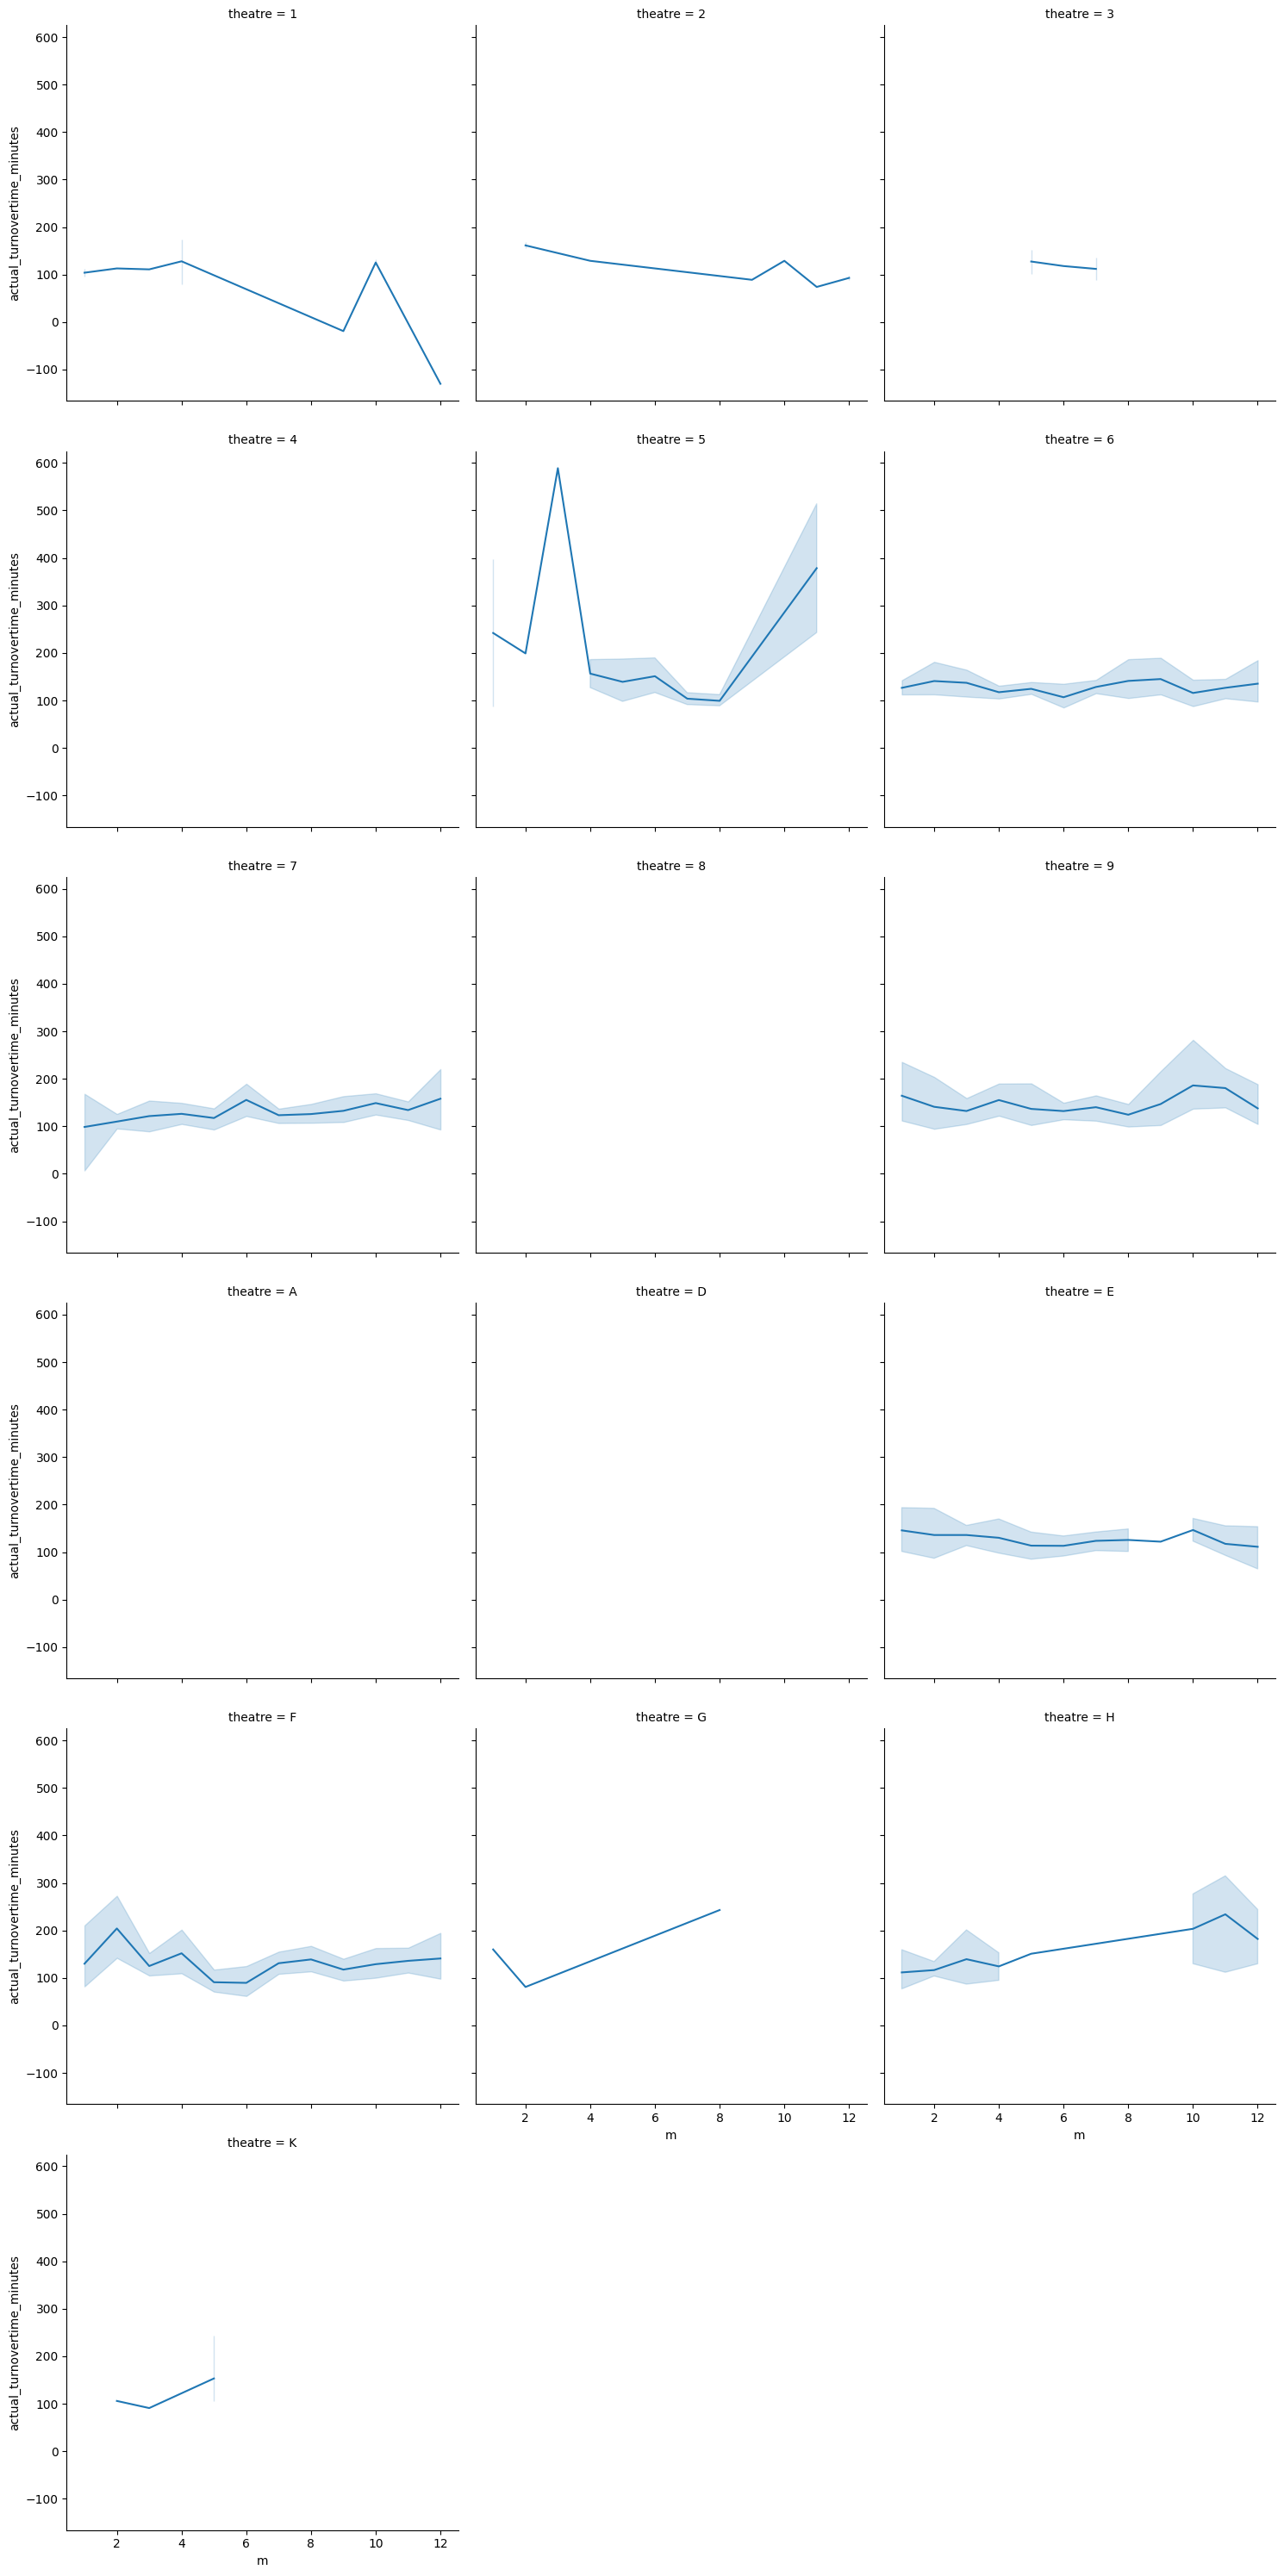

In [22]:
sns.relplot( 
    data=df,
    x="m",
    y="actual_turnovertime_minutes",
    kind="line",
    col="theatre",
    col_wrap=3
)